### Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor

from keras.models import Sequential
from keras.layers import LSTM, Dense

### Import Dataset

In [3]:
df = pd.read_excel("bitcoin dataset.xlsx", index_col = "timestamp", parse_dates = ["timestamp"])
df.head()

,close_5m,close_15m,close_30m,close_1H,close_4H,close_1D
timestamp,,,,,,
2019-08-01 13:07:19,10030.2,10035.0,10040.0,9995.3,10290.0,10531.5
2019-08-01 13:07:19,10030.2,10035.0,10040.0,9995.3,10290.0,10531.5
2019-08-01 14:46:07,9995.0,9985.9,10015.4,10020.4,10290.0,10531.5
2019-08-01 15:14:54,9996.6,10015.4,10020.4,10070.1,10290.0,10531.5
2019-08-01 17:16:12,10039.7,10059.4,10104.5,10192.5,10408.9,10531.5


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1048575 entries, 2019-08-01 13:07:19 to 2019-08-15 09:43:10
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   close_5m   1048361 non-null  float64
 1   close_15m  1048575 non-null  float64
 2   close_30m  1048575 non-null  float64
 3   close_1H   1048575 non-null  float64
 4   close_4H   1048575 non-null  float64
 5   close_1D   1048575 non-null  float64
dtypes: float64(6)
memory usage: 56.0 MB


In [5]:
df = df.astype("float16")

In [6]:
df = df.dropna()

In [8]:
# Use last 50k rows as data is very large
len(df) * 0.95

995942.95

In [9]:
df = df.iloc[995942:]

In [10]:
X = df[df.columns.drop("close_1D")]
y = df["close_1D"]

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)

In [12]:
scaler = StandardScaler()

X_train_scaler = scaler.fit_transform(X_train)

X_test_scaler = scaler.transform(X_test)

### SVM REGRESSION

In [13]:
svm = SVR()

svm.fit(X_train, y_train)

svm_pred = svm.predict(X_test)

svm_pred_data = pd.DataFrame({"Actual": y_test,
                              "Predicted": svm_pred})
svm_pred_data

,Actual,Predicted
timestamp,,
2019-08-15 06:29:56,10360.0,10360.100492
2019-08-15 06:29:29,10360.0,10360.100492
2019-08-15 06:29:34,10360.0,10360.100492
2019-08-15 06:29:55,10360.0,10360.100492
2019-08-15 13:59:22,10360.0,10351.216557
...,...,...
2019-08-15 09:42:41,10360.0,10337.568144
2019-08-15 09:43:01,10360.0,10337.568144
2019-08-15 09:43:06,10360.0,10337.568144


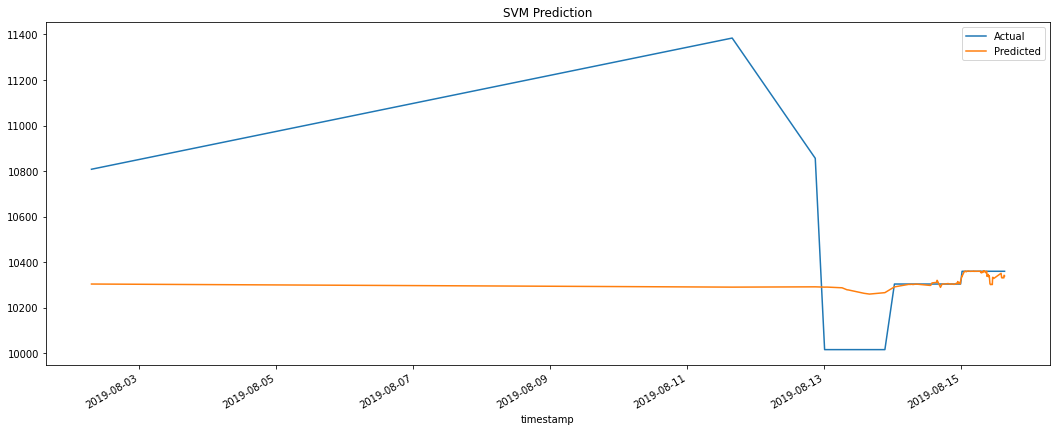

In [14]:
svm_pred_data.plot(figsize = (18, 7), title = "SVM Prediction");

In [15]:
mae_svr = mean_absolute_error(y_test, svm_pred)
print("Mean Absolute Error =", mae_svr)

Mean Absolute Error = 7.785028745730548


### Gradient Boosting Regression

In [16]:
gbr = GradientBoostingRegressor()

gbr.fit(X_train, y_train)

gbr_pred = gbr.predict(X_test)

gbr_pred_data = pd.DataFrame({"Actual": y_test,
                              "Predicted": gbr_pred})
gbr_pred_data

,Actual,Predicted
timestamp,,
2019-08-15 06:29:56,10360.0,10359.951670
2019-08-15 06:29:29,10360.0,10359.951670
2019-08-15 06:29:34,10360.0,10359.951670
2019-08-15 06:29:55,10360.0,10359.951670
2019-08-15 13:59:22,10360.0,10359.951670
...,...,...
2019-08-15 09:42:41,10360.0,10360.001899
2019-08-15 09:43:01,10360.0,10360.001899
2019-08-15 09:43:06,10360.0,10360.001899


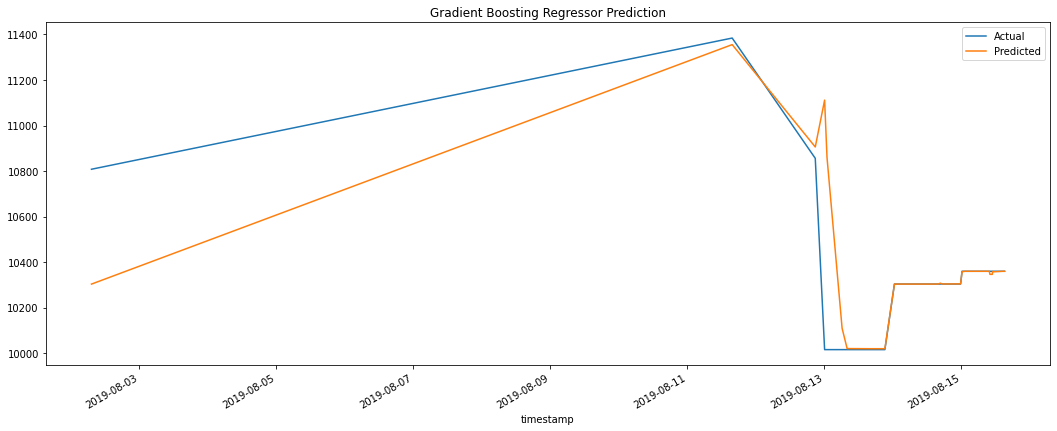

In [17]:
gbr_pred_data.plot(figsize = (18, 7), title = "Gradient Boosting Regressor Prediction");

### LSTM

**Data Preparation**

In [18]:
feature = df["close_1D"]

In [21]:
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):

        end_ix = i + n_steps

        if end_ix > len(sequence)-1:
            break

        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence
raw_seq = feature.tolist()

n_steps = 3

X, y = split_sequence(raw_seq, n_steps)

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.2,
                                                    shuffle = False)

In [23]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))

In [24]:
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [30]:
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(3, 1)))
model.add(Dense(1))
model.compile(optimizer='Adam', loss='mse')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 50)                10400     
                                                                 
 dense_2 (Dense)             (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [31]:
model.fit(X_train, y_train, epochs=50)

Epoch 1/50
1311/1311 [==============================] - 7s 4ms/step - loss: 27782012.0000
Epoch 2/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1296.6208
Epoch 3/50
1311/1311 [==============================] - 5s 3ms/step - loss: 1301.2172
Epoch 4/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1310.6976
Epoch 5/50
1311/1311 [==============================] - 5s 3ms/step - loss: 1336.4459
Epoch 6/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1372.1045
Epoch 7/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1402.3541
Epoch 8/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1409.8936
Epoch 9/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1420.0818
Epoch 10/50
1311/1311 [==============================] - 5s 3ms/step - loss: 1428.1376
Epoch 11/50
1311/1311 [==============================] - 5s 4ms/step - loss: 1430.9109
Epoch 12/50
1311/1311 [=========================

In [32]:
pred_lstm = model.predict(X_test)
pred_lstm_data = pd.DataFrame({"Actual": y_test,
                               "Predicted": pred_lstm.flatten()})
pred_lstm_data.tail(10)

,Actual,Predicted
10474,10360.0,10356.717773
10475,10360.0,10356.717773
10476,10360.0,10356.717773
10477,10360.0,10356.717773
10478,10360.0,10356.717773
10479,10360.0,10356.717773
10480,10360.0,10356.717773
10481,10360.0,10356.717773
10482,10360.0,10356.717773
10483,10360.0,10356.717773


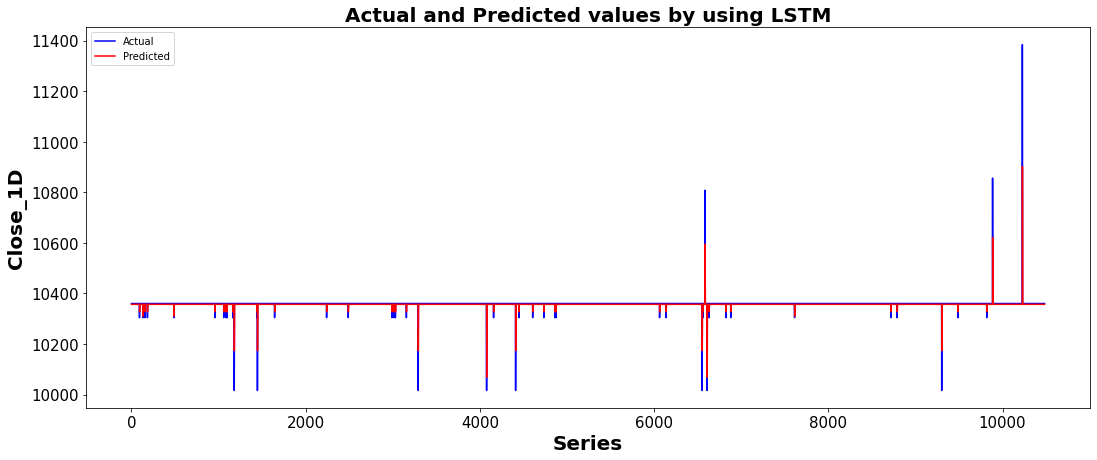

In [36]:
plt.figure(figsize = (18, 7))
sns.lineplot(data = pred_lstm_data["Actual"], color = "blue", label = "Actual")
sns.lineplot(data = pred_lstm_data["Predicted"], color = "red", label = "Predicted")
plt.title("Actual and Predicted values by using LSTM", size = 20, weight = "bold")
plt.xlabel("Series", weight = "bold", size = 20)
plt.ylabel("Close_1D", weight = "bold", size = 20)
plt.xticks(size = 15)
plt.yticks(size = 15)
plt.legend()
plt.show()